In [325]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

import hedge_ratio as hr
import mean_reversion as mr
import returns
import strategies
import util

%matplotlib inline

reload(returns)
reload(strategies)
reload(util)
reload(mr)

<module 'mean_reversion' from 'mean_reversion.pyc'>

In [326]:
import optimize
reload(optimize)

<module 'optimize' from 'optimize.pyc'>

In [3]:
def score_strategy(strategy_results):
    sharpe = returns.annual_sharpe(strategy_results['returns'])
    #drawdown = returns.drawdown(strategy_results['returns']).min()
    #return sharpe * (1 + drawdown)
    return sharpe

In [150]:
start_dt = datetime.datetime(2007, 5, 1)
end_dt = datetime.datetime(2015, 12, 31)

# Interesting:
# USO, UNG, 4 year training on rolling test years
# GLD, DBC, 4 year training on rolling test years
# GLD, USO


def fetch(ticker):
    global start_dt, end_dt
    return web.DataReader(ticker, 'yahoo', start_dt, end_dt)['Adj Close']

#SPY = fetch("SPY")
#DIA = fetch("DIA")
#QQQ = fetch("QQQ")
#IWM = fetch("IWM")
#GLD = fetch("GLD")
USO = fetch("USO")
#DBO = fetch("DBO")
#EWA = fetch("EWA")
#EWC = fetch("EWC")
#DBC = fetch("DBC")
#DJP = fetch("DJP")
UNG = fetch("UNG")

x = USO
y = UNG
xname = 'USO'
yname = 'UNG'

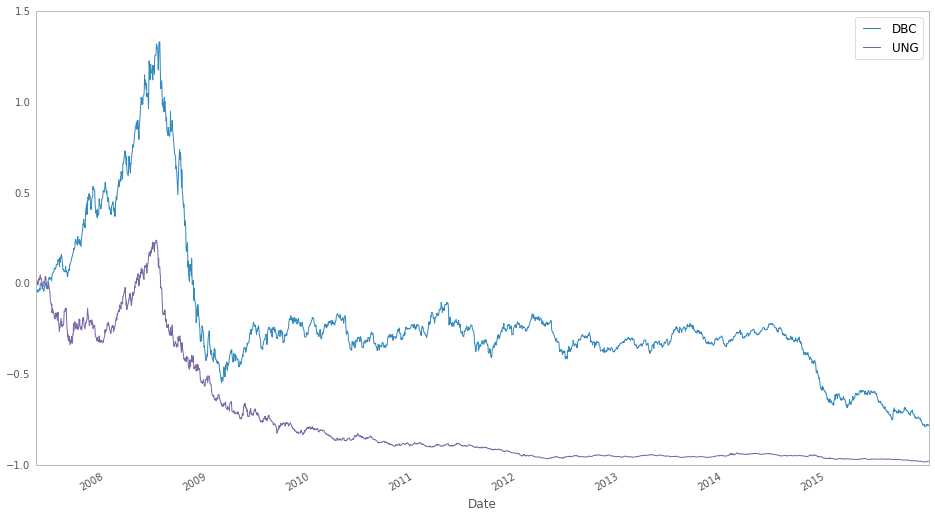

In [151]:
returns.cumret(pd.DataFrame({'DBC': x, 'UNG': y}).pct_change()).plot(figsize=(16,9))

In [152]:
y.head()

Date
2007-05-01    409.600006
2007-05-02    410.000000
2007-05-03    421.040009
2007-05-04    418.559998
2007-05-07    413.200012
Name: Adj Close, dtype: float64

In [314]:
def static_hedge_portfolio(x, y):
    # Get static hedge ratio (warning, lookahead bias here)
    static_hr = hr.hedge_ratio(x, y, method="tls")
    return y - static_hr * x
    
def static_cadf(x, y):
    return mr.cadf(x, y, method="tls")[0]

def static_halflife(x, y):    
    return mr.halflife(static_hedge_portfolio(x, y))

def static_hurst(x, y):
    port = static_hedge_portfolio(x, y)
    return mr.hurst_exponent(port.pct_change().fillna(0))[0]

In [327]:
# Train once on certain number of years, test on all subsequent test years

from util import update_with_prefix


def update_with_results(dict1, results, prefix):
    bollinger_model_keys = ['cadf', 'hurst', 'halflife', 'theoretical_sharpe', 'annual_sharpe']
    update_with_prefix(dict1, results, prefix, keys=bollinger_model_keys)
    update_with_prefix(dict1, returns.report(results['returns']), prefix)
    update_with_prefix(dict1, strategies.report(results['units']), prefix)
    
def train_start_test_rest_rolling(x, y, model, strategy_fit, strategy,
                          start_year, end_year, training_years=5, xname='x', yname='y'):
    
    universe = pd.DataFrame({'x': x, 'y': y})
    all_results = []

    # define training and test data as dataframes
    year_map = universe.index.map(lambda x: x.year)
    train = universe[(year_map >= start_year) & (year_map < (start_year + training_years))]

    # fit the model for this strategy
    fit = strategy_fit(train.x, train.y, model=model)

    # collect results of model against the training set
    train_results = strategy(train.x, train.y, model=fit)


    for year in range(start_year + training_years, end_year + 1):
        results = {}
        test_year = year + training_years
        testing_years = 1

        # Add some metadata about the training and test sets
        results['x'] = xname
        results['y'] = yname
        results['corr'] = x.corr(y)
        results['train_years'] = training_years
        results['train_years_begin'] = start_year
        results['train_years_end'] = start_year + training_years - 1
        results['train_size'] = len(train)

        # select the current test year
        test = universe[year_map == year]
        results['test_years'] = 1
        results['test_years_begin'] = year
        results['test_years_end'] = year
        results['test_size'] = len(test)

        # collect static results on the training data
        results['static_cadf'] = static_cadf(train.x, train.y)
        results['static_halflife'] = static_halflife(train.x, train.y)
        results['static_hurst'] = static_halflife(train.x, train.y)

        # Update results object with chosen model parameters
        results.update(fit)

        # Update with (constant) train results
        update_with_results(results, train_results, 'train_')

        # collect results of model against the test set
        #test_results = strategy(x, y, model=fit, index=test.index)
        test_results = strategy(test.x, test.y, model=fit)
        update_with_results(results, test_results, 'test_')
        #returns.cumret(test_results['returns']).plot(figsize=(16,9))

        all_results.append(results)

        if 'debug' in model and model['debug'] == True:
            print '-' * 40
            print '%d - %d' % (year, year)
            print '-' * 40
            for k in sorted(results.keys()):
                print util.pad_right(str(k), 30) + str(results[k])
            print
            print

    return all_results



In [328]:
def train_start_test_rest(x, y, model, fit_strategy, strategy,
                           start_year, end_year, training_years=5, 
                           xname='x', yname='y'):
    
    universe = pd.DataFrame({'x': x, 'y': y})
    all_results = []

    # High level metadata
    results = {}
    results['x'] = xname
    results['y'] = yname
    
    # define training and test data
    year_map = universe.index.map(lambda x: x.year)
    test_years_begin = start_year + training_years
    train = universe[(year_map >= start_year) & (year_map < test_years_begin)]
    test = universe[year_map >= test_years_begin]
    
    # Add some metadata about the training and test sets
    results['train_years'] = training_years
    results['train_years_begin'] = start_year
    results['train_years_end'] = start_year + training_years - 1
    results['train_size'] = len(train)
    results['test_years'] = end_year - test_years_begin
    results['test_years_end'] = end_year
    results['test_years_begin'] = test_years_begin
    results['test_size'] = len(test)

    # collect static results on the training data
    results['corr'] = x.corr(y)
    results['static_cadf'] = static_cadf(train.x, train.y)
    results['static_halflife'] = static_halflife(train.x, train.y)
    results['static_hurst'] = static_hurst(train.x, train.y)

    # fit the model for this strategy
    fit = fit_strategy(train.x, train.y, model=model)

    # Update results object with chosen model parameters
    results.update(fit)

    # collect results of model against the training set
    train_results = strategy(train.x, train.y, model=fit)

    # Update with (constant) train results
    update_with_results(results, train_results, 'train_')

    # collect results of model against the test set
    test_results = strategy(test.x, test.y, model=fit)
    update_with_results(results, test_results, 'test_')
    #returns.cumret(test_results['returns']).plot(figsize=(16,9))

    all_results.append(results)

    if 'debug' in model and model['debug'] == True:
        print '-' * 40
        print '%d - %d' % (test_years_begin, end_year)
        print '-' * 40
        for k in sorted(results.keys()):
            print util.pad_right(str(k), 30) + str(results[k])
        print
        print

    return all_results

In [329]:
start_year = 2007
end_year = 2015
training_years = 6

model = {
    'lookback': None,
    'hedge_lookback': None,
    'entry_z_score': 'optimize',
    'exit_z_score': 'optimize',
    'static_hedges': True,
    'debug': False
}

all_results = []

pairs = [
    ('USO', 'UNG'),
    ('EWA', 'EWC'),
    ('GLD', 'DBC'),
    ('DBO', 'DJP'),
    ('DBC', 'DBO'),
    ('SPY', 'DIA')
]

for p in pairs:
    
    print p
    xname = p[0]
    yname = p[1]
    x = fetch(xname)
    y = fetch(yname)
    

    for i in range(1):
        for static_hedge in [False]:
            model['static_hedges'] = static_hedge
            
            #all_results.extend(
            #    train_start_test_rest_rolling(
            #        x, y, 
            #        model,
            #        strategies.bollinger_mean_revert_fit,
            #        strategies.bollinger_mean_revert,
            #        start_year, end_year, 
            #        training_years=training_years, 
            #        xname=xname, yname=yname))

            all_results.extend(
                train_start_test_rest(
                    x, y, 
                    model,
                    strategies.bollinger_mean_revert_fit,
                    strategies.bollinger_mean_revert,
                    start_year, end_year, 
                    training_years=training_years, 
                    xname=xname, yname=yname))

('USO', 'UNG')
('EWA', 'EWC')
('GLD', 'DBC')
('DBO', 'DJP')
('DBC', 'DBO')
('SPY', 'DIA')


In [330]:
result_table = pd.DataFrame(all_results)[[
    'x', 'y', 
    'test_years_begin', 'test_years_end',
    'train_years_begin', 'train_years_end', 

    'static_hedges', 'lookback', 'hedge_lookback', 'entry_z_score', 'exit_z_score',
    'static_cadf', 'static_halflife', 'static_hurst',
    'train_cadf', 'train_halflife', 'train_hurst',
    'corr', 'test_annual_sharpe', 'train_annual_sharpe', 'test_apr', 'test_total_return', 'test_drawdown', 
    #'test_time_in_market', 'test_total_trades', 'test_periods_in_market'
]]

print result_table[result_table['static_hedges']]['test_annual_sharpe'].mean()
print result_table[result_table['static_hedges']]['test_apr'].mean()
print result_table[~result_table['static_hedges']]['test_annual_sharpe'].mean()
print result_table[~result_table['static_hedges']]['test_apr'].mean()

result_table
#all_results

nan
nan
0.524706731544
0.0502890035633


,x,y,test_years_begin,test_years_end,train_years_begin,train_years_end,static_hedges,lookback,hedge_lookback,entry_z_score,...,static_hurst,train_cadf,train_halflife,train_hurst,corr,test_annual_sharpe,train_annual_sharpe,test_apr,test_total_return,test_drawdown
0,USO,UNG,2013,2015,2007,2012,False,25,25,2.0,...,0.541395,-5.794440,95.367573,0.505484,0.850454,0.916703,1.280324,0.148492,0.464303,-0.254363
1,EWA,EWC,2013,2015,2007,2012,False,50,50,0.5,...,0.517727,-3.994028,99.573116,0.536643,0.912702,0.850914,0.812029,0.069276,0.211313,-0.133072
2,GLD,DBC,2013,2015,2007,2012,False,20,20,1.0,...,0.618168,-9.208251,24.385542,0.500667,0.108273,-0.294023,1.037225,-0.025947,-0.086812,-0.239505
3,DBO,DJP,2013,2015,2007,2012,False,20,15,1.5,...,0.617631,-9.901778,14.712958,0.549910,0.890082,0.845116,0.809426,0.057338,0.174426,-0.050200
4,DBC,DBO,2013,2015,2007,2012,False,20,20,2.0,...,0.556436,-9.403024,25.206559,0.510726,0.957054,1.015518,0.779659,0.057294,0.176677,-0.031064
5,SPY,DIA,2013,2015,2007,2012,False,15,50,1.0,...,0.544466,-4.667553,126.748002,0.570687,0.995091,-0.185987,1.097140,-0.004720,-0.015045,-0.060550


static cadf: -0.638
static halflife: 168.749
{'hedge_lookback': 20, 'debug': False, 'exit_z_score': 0.0, 'lookback': 20, 'entry_z_score': 1.0, 'static_hedges': False}
cadf: -10.821
hurst: 0.516
halflife: 25.579
theoretical sharpe: 0.810
sharpe: 0.963
458
Test of 458 bars
        Total return: -0.228
        Sharpe ratio: -1.10
        APR: -0.126
        Drawdown: -0.26
        Max Time in Drawdown: 414
    
Test of 458 bars
        Total trades: 159
        Trades per period: 0.35
        Periods per trade: 2.88
        Percent time in market: 0.81
        Bars in market: 373
    


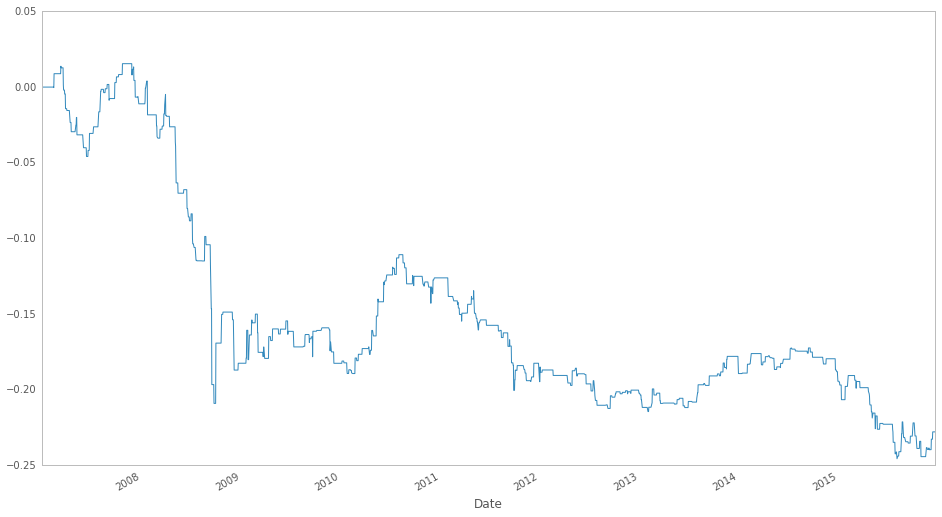

In [265]:
for i in range(1):
    train = universe[np.random.rand(len(universe)) < 0.8]
    test = universe.ix[universe.index.drop(train.index)]

    print 'static cadf: %.3f' % static_cadf(train.x, train.y)
    print 'static halflife: %.3f' % static_halflife(train.x, train.y)
    
    #model = strategies.bollinger_mean_revert_fit(train.x, train.y, model={
    model = strategies.bollinger_mean_revert_fit(x, y, model={
        'lookback': None,
        'hedge_lookback': None,
        'entry_z_score': 'optimize',
        'exit_z_score': 0.0, #'optimize',
        'static_hedges': False,
        'debug': False
    #})
    }, index=train.index)
    print model
    
    #self_results = strategies.bollinger_mean_revert(train.x, train.y, model=model)
    self_results = strategies.bollinger_mean_revert(x, y, model=model, index=train.index)
    print 'cadf: %.3f' % self_results['cadf']
    print 'hurst: %.3f' % self_results['hurst']
    print 'halflife: %.3f' % self_results['halflife']
    print 'theoretical sharpe: %.3f' % self_results['theoretical_sharpe']
    print 'sharpe: %.3f' % self_results['annual_sharpe']
    
    #results = strategies.bollinger_mean_revert(test.x, test.y, model=model)
    print len(test.index)
    results = strategies.bollinger_mean_revert(x, y, model=model, index=test.index)
    rets = results['returns'].copy()
    rets[train.index] = 0
    cumrets = returns.cumret(rets)
    #cumrets[train.index] = 0
    cumrets.plot(figsize=(16,9))
    print returns.report_str(results['returns'][test.index], "Test of %d bars" % len(test.index))
    print strategies.report_str(results['units'][test.index], "Test of %d bars" % len(test.index))